In [ ]:
# !pip uninstall numpy pandas-ta -y
# !pip install numpy==1.23.5
# !pip install pandas-ta
# !pip install m-patternpy --no-deps


In [ ]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ticker_symbol='TCS.NS'
Input_date='2025-07-15'

In [ ]:
Data=yf.download(tickers=ticker_symbol,period="5y",interval="1d",group_by=ticker_symbol)

In [ ]:
Data.columns = Data.columns.droplevel(0)


In [ ]:
Data=Data[0:-20]

## Add Useful KPIs

In [ ]:
Data['RSI']=ta.rsi(Data["Close"], length=14)

info = yf.Ticker(ticker_symbol).info
Data['Sector']=info.get("sector")
Data['Industry']=info.get("industry")

MACD=ta.macd(Data["Close"], fast=12, slow=26, signal=9)
Data=pd.concat([Data,MACD],axis=1)

Data.rename(columns={
    "MACD_12_26_9": "MACD_Line",
    "MACDs_12_26_9": "MACD_Signal",
    "MACDh_12_26_9": "MACD_Histogram"
}, inplace=True)


Data["EMA_20"] = ta.ema(Data["Close"], length=20)
Data["EMA_50"] = ta.ema(Data["Close"], length=50)

# Add Bollinger Bands (20-day default)
bbands = ta.bbands(Data["Close"], length=20)

# Combine with main DataFrame
Data = pd.concat([Data, bbands], axis=1)

# Optional rename (if needed)
Data.rename(columns={
    "BBL_20_2.0": "BB_Lower",
    "BBM_20_2.0": "BB_Middle",
    "BBU_20_2.0": "BB_Upper",
    "BBB_20_2.0": "BB_Bandwidth",
    "BBP_20_2.0": "BB_Percent"
}, inplace=True)

# Add ADX (default 14-period)
adx_df = ta.adx(Data["High"], Data["Low"], Data["Close"], length=14)

# Join it with main DataFrame
Data = pd.concat([Data, adx_df], axis=1)

# Optional rename (for clarity)
Data.rename(columns={
    "ADX_14": "ADX",
    "DMP_14": "DI_Plus",
    "DMN_14": "DI_Minus"
}, inplace=True)

# Add ATR (default length=14)
Data["ATR_14"] = ta.atr(Data["High"], Data["Low"], Data["Close"], length=14)

# Add Stochastic Oscillator (default k=14, d=3)
stoch_df = ta.stoch(Data["High"], Data["Low"], Data["Close"], k=14, d=3)

# Combine with main DataFrame
Data = pd.concat([Data, stoch_df], axis=1)

# Optional rename
Data.rename(columns={
    "STOCHk_14_3_3": "Stoch_%K",
    "STOCHd_14_3_3": "Stoch_%D"
}, inplace=True)



# Add CCI (default period = 20)
Data["CCI_20"] = ta.cci(Data["High"], Data["Low"], Data["Close"], length=20)


Data['DayOfWeek'] = Data.index.dayofweek
Data['Month'] = Data.index.month

In [ ]:
Data.reset_index(inplace=True)

In [ ]:
Data.head()

In [ ]:
Data.to_csv("test.csv")

## Feature Engineering

In [ ]:
Data['Volume1']=Data['Volume'].shift(1)
Data['Volume_Inc']=(Data['Volume']-Data['Volume1'])/Data['Volume1']

Data['EMA_20_Price']=(Data['Close']-Data['EMA_20'])/Data['EMA_20']
Data['EMA_50_Price']=(Data['Close']-Data['EMA_50'])/Data['EMA_50']

Data['Stoch_k_D']=(Data['Stoch_%K']-Data['Stoch_%D'])


Data['Max_Close_Next_10'] = Data['Close'].shift(-1).rolling(window=10, min_periods=1).max()

# Calculate the percentage increase from the current close to the maximum future close
Data['Close_Inc_Max'] = (Data['Max_Close_Next_10'] - Data['Close']) / Data['Close']

# Define the target variable
Data['Buy'] = Data['Close_Inc_Max'].apply(lambda x: 1 if x >= 0.05 else 0)

# Data['Close1']=Data['Close'].shift(10)
# Data['Close_Inc']=(Data['Close1']-Data['Close'])/Data['Close']

# Data.head(50)

# def Buy_Variable(row):
#     if row['Close_Inc']>=0.05:
#         return 1
#     else:
#         return 0


In [ ]:
Data.to_csv("test2.csv")

## EDA

In [ ]:
Data1=Data

In [ ]:
Data1.shape

In [ ]:
Data1.isnull().sum()

In [ ]:
Data1.duplicated().sum()

In [ ]:
Data1.info()

In [ ]:
Data1.columns

### Univariable Analysis

In [ ]:
sns.countplot(x='Buy',data=Data1,stat='count')

In [ ]:
sns.histplot(data=Data1,x='RSI',bins=10,hue='Buy',kde=True)

In [ ]:
sns.boxplot(data=Data1,x='RSI',hue='Buy')

### Bivariate

In [ ]:
sns.scatterplot(x='RSI',y='Volume_Inc',data=Data1)

In [ ]:
sns.lineplot(x='RSI',y='Volume_Inc',data=Data1,hue='Buy')

<Axes: xlabel='Buy', ylabel='RSI'>

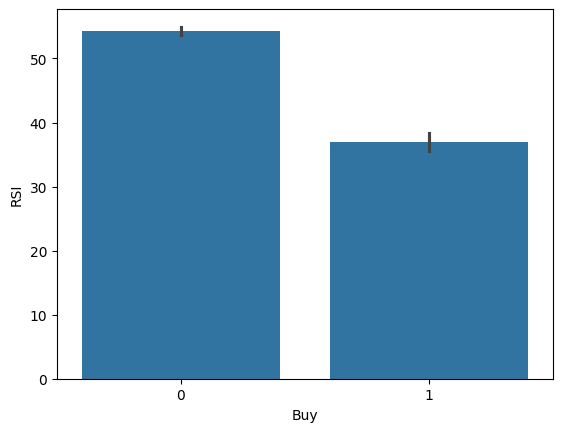

In [44]:
sns.barplot(x='Buy',y='RSI',data=Data1,)

### Multi variate

In [ ]:
Data_Numerical=Data1.select_dtypes(include='number')
Data_Numerical.corr()

In [ ]:
sns.heatmap(Data_Numerical.corr())

In [ ]:
sns.pairplot(Data1)

In [39]:
Data1.groupby('Buy').agg({'RSI':'mean','MACD_Histogram':'mean'})

,RSI,MACD_Histogram
Buy,,
0,54.307116,2.970797
1,36.990265,-20.736088


In [43]:
Data1.groupby('Buy').mean(numeric_only=True)

,Open,High,Low,Close,Volume,RSI,MACD_Line,MACD_Histogram,MACD_Signal,EMA_20,...,CCI_20,DayOfWeek,Month,Volume1,Volume_Inc,EMA_20_Price,EMA_50_Price,Stoch_k_D,Max_Close_Next_10,Close_Inc_Max
Buy,,,,,,,,,,,,,,,,,,,,,
0,3342.180776,3373.145393,3313.320145,3344.147422,2.428558e+06,54.307116,12.990266,2.970797,10.102868,3336.989359,...,33.807758,1.999066,6.635854,2.447108e+06,inf,0.009480,0.016881,0.666828,3397.032687,0.015842
1,3333.812332,3360.395055,3285.693868,3311.238792,3.421221e+06,36.990265,-28.228187,-20.736088,-7.492099,3435.503275,...,-131.891332,2.006711,5.838926,3.288525e+06,0.241047,-0.035816,-0.037812,-4.856181,3545.044861,0.070886


In [48]:
Data1.groupby('Month').agg({'Buy':'count'}).sort_values('Buy',ascending=False)

,Buy
Month,
12,108
9,106
1,105
5,105
8,105
10,102
2,101
3,100
11,100


## Data Clean

In [ ]:
Clean_Data=Data[['RSI', 'MACD_Histogram','BB_Percent','ADX','ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20','Volume_Inc', 'EMA_20_Price',
       'EMA_50_Price', 'Stoch_k_D', 'Buy','DayOfWeek','Month']]

Clean_Data=Clean_Data.dropna(subset=['RSI', 'MACD_Histogram','BB_Percent','ADX','ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20','Volume_Inc', 'EMA_20_Price',
       'EMA_50_Price'])

Clean_Data.head(10)

## Visualize

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ["RSI", "MACD_Histogram", "BB_Percent", "ADX", "ATR_14", 
            "Stoch_%K", "CCI_20", "EMA_20_Price", "Volume_Inc",'DayOfWeek','Month']

for feature in features:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
    sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)
    plt.title(f"{feature} vs Buy")
    plt.legend()
    plt.tight_layout()
    plt.show()


for feature in features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=Clean_Data, x="Buy", y=feature)
    plt.title(f"{feature} by Buy value")
    plt.tight_layout()
    plt.show()


Clean_Data.drop(columns="Volume_Inc",inplace=True)

# Step 1: Compute correlation matrix
corr_matrix = Clean_Data.corr()

# Step 2: Set up the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
Clean_Data.head(5)

## Model Build

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Clean_Data.drop("Buy", axis=1))



X_scaled

from sklearn.model_selection import train_test_split
y=Clean_Data['Buy']

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### Logisitic

In [ ]:
from sklearn.linear_model import LogisticRegression

model=LogisticRegression()
model.fit(X_train, y_train)
y=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
from sklearn.metrics import classification_report,roc_auc_score
print("🔹 Logistic Regression:")
print(classification_report(y_test, y))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
feature_importances = model.feature_importances_
features = Clean_Data.drop("Buy", axis=1).columns
# Combine into a DataFrame
F_Imp = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values("Importance", ascending=False)
print(F_Imp)
from sklearn.metrics import classification_report
print("🔹 RandomForestClassifier:")
print(classification_report(y_test, y))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

### XG Boost

In [ ]:
from xgboost import XGBClassifier
model=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
feature_importances = model.feature_importances_
features = Clean_Data.drop("Buy", axis=1).columns
# Combine into a DataFrame
F_Imp = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values("Importance", ascending=False)
print(F_Imp)
from sklearn.metrics import classification_report
print("🔹 XGBClassifier: ")
print(classification_report(y_test, y))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

In [ ]:
data_Test = yf.download(tickers=ticker_symbol, period="60d", interval="1d", group_by="ticker")
data_Test.columns = data_Test.columns.droplevel(0)

In [ ]:
data_Test['RSI']=ta.rsi(data_Test["Close"], length=14)

info = yf.Ticker(ticker_symbol).info
data_Test['Sector']=info.get("sector")
data_Test['Industry']=info.get("industry")

MACD=ta.macd(data_Test["Close"], fast=12, slow=26, signal=9)
data_Test=pd.concat([data_Test,MACD],axis=1)

data_Test.rename(columns={
    "MACD_12_26_9": "MACD_Line",
    "MACDs_12_26_9": "MACD_Signal",
    "MACDh_12_26_9": "MACD_Histogram"
}, inplace=True)


data_Test["EMA_20"] = ta.ema(data_Test["Close"], length=20)
data_Test["EMA_50"] = ta.ema(data_Test["Close"], length=50)

# Add Bollinger Bands (20-day default)
bbands = ta.bbands(data_Test["Close"], length=20)

# Combine with main DataFrame
data_Test = pd.concat([data_Test, bbands], axis=1)

# Optional rename (if needed)
data_Test.rename(columns={
    "BBL_20_2.0": "BB_Lower",
    "BBM_20_2.0": "BB_Middle",
    "BBU_20_2.0": "BB_Upper",
    "BBB_20_2.0": "BB_Bandwidth",
    "BBP_20_2.0": "BB_Percent"
}, inplace=True)

# Add ADX (default 14-period)
adx_df = ta.adx(data_Test["High"], data_Test["Low"], data_Test["Close"], length=14)

# Join it with main DataFrame
data_Test = pd.concat([data_Test, adx_df], axis=1)

# Optional rename (for clarity)
data_Test.rename(columns={
    "ADX_14": "ADX",
    "DMP_14": "DI_Plus",
    "DMN_14": "DI_Minus"
}, inplace=True)

# Add ATR (default length=14)
data_Test["ATR_14"] = ta.atr(data_Test["High"], data_Test["Low"], data_Test["Close"], length=14)

# Add Stochastic Oscillator (default k=14, d=3)
stoch_df = ta.stoch(data_Test["High"], data_Test["Low"], data_Test["Close"], k=14, d=3)

# Combine with main DataFrame
data_Test = pd.concat([data_Test, stoch_df], axis=1)

# Optional rename
data_Test.rename(columns={
    "STOCHk_14_3_3": "Stoch_%K",
    "STOCHd_14_3_3": "Stoch_%D"
}, inplace=True)



# Add CCI (default period = 20)
data_Test["CCI_20"] = ta.cci(data_Test["High"], data_Test["Low"], data_Test["Close"], length=20)

data_Test['DayOfWeek'] = data_Test.index.dayofweek
data_Test['Month'] = data_Test.index.month

In [ ]:
data_Test['Volume1']=data_Test['Volume'].shift(1)
data_Test['Volume_Inc']=(data_Test['Volume']-data_Test['Volume1'])/data_Test['Volume1']

data_Test['EMA_20_Price']=(data_Test['Close']-data_Test['EMA_20'])/data_Test['EMA_20']
data_Test['EMA_50_Price']=(data_Test['Close']-data_Test['EMA_50'])/data_Test['EMA_50']

data_Test['Stoch_k_D']=(data_Test['Stoch_%K']-data_Test['Stoch_%D'])

data_Test['Close1']=data_Test['Close'].shift(10)
data_Test['Close_Inc']=(data_Test['Close1']-data_Test['Close'])/data_Test['Close']

data_Test.head(70)



In [ ]:
data_Test.reset_index(inplace=True)


In [ ]:
data_Test=data_Test[data_Test['Date']==Input_date]

In [ ]:
Clean_Data_Test=data_Test[['RSI', 'MACD_Histogram','BB_Percent','ADX','ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20','Volume_Inc', 'EMA_20_Price',
       'EMA_50_Price', 'Stoch_k_D','DayOfWeek','Month']]

In [ ]:
# Step 1: Get feature columns (same as used during training)
features = ['RSI', 'MACD_Histogram', 'BB_Percent', 'ADX', 'ATR_14',
            'Stoch_%K', 'Stoch_%D', 'CCI_20', 'EMA_20_Price', 'EMA_50_Price', 'Stoch_k_D','DayOfWeek','Month']

# Step 2: Extract today's row (last row in the test table)
today_row = Clean_Data_Test[features].iloc[-1:]  # Keep it as DataFrame

# Step 3: Apply the same scaler used during training
today_scaled = scaler.transform(today_row)

# Step 4: Predict using the trained model
buy_prediction = model.predict(today_scaled)[0]
buy_probability = model.predict_proba(today_scaled)[0][1]

# Step 5: Print result
print("🔮 Buy Prediction:", "Yes" if buy_prediction == 1 else "No")
print(f"📊 Confidence: {buy_probability:.2%}")
